In [2]:
import matscipy
from matscipy import calculators
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch import nn
from torch.functional import F
from copy import copy
from itertools import combinations
import time
from torch.profiler import profile, record_function, ProfilerActivity
from scipy import constants
import sys
from torch.utils.tensorboard import SummaryWriter

def supercell_gen(cell_num1, cell_num2):
    atom_pos1 = cell_num1*2 + 1
    atom_pos2 = cell_num2*2 + 1
    zero_cell = np.zeros(((atom_pos1, atom_pos2)))
    for i in range(atom_pos1):
        for j in range(atom_pos2):
            if i%2 == 1:
                zero_cell[i][j] = abs(j%2)
            elif i%2 == 0:
                zero_cell[i][j] = 1 - abs(j%2)
    return zero_cell

In [9]:
#* Read NC's potential for CrCoNi
eam_pth = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/pyMD/2D_try/EAM/NiCoCr.lammps_t1.eam'
_, param, f_s, rhof_s, phi_r = calculators.eam.io.read_eam(eam_pth, kind='eam/alloy')

Parameters based on Zhou et al's work

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.69.144113

### Main:
$$E = 1/2\sum_{i \neq j}\phi_{ij}(r_{ij}) + \sum_{i}F_i(\rho_i) \tag{1-1}$$

$$f(r) = \frac{f_e e^{-\beta(r/r_e-1)}}{1+(r/r_e-\lambda)^{20}} \tag{1-2}$$

*variable: f_e, beta, lamda*

#### Potential

$$\phi(r) = \frac{Ae^{-\alpha(r/r_e-1)}}{1+(r/r_e-\kappa)^{20}}-\frac{Be^{-\beta(r/r_e-1)}}{1+(r/r_e-\lambda)^{20}} \tag{2-1}$$

*variable: A, B, alpha, beta, kappa, lamda, r_e*

$$\phi^{ab}(r) = 1/2[\frac{f^b(r)}{f^a(r)}\phi^{aa}(r)+\frac{f^a(r)}{f^b(r)}\phi^{bb}(r)] \tag{2-2}$$

#### Density of electron

$$\rho_i = \sum_{j \neq i}f_j(r_{ij}) \tag{3-1}$$

$$F(\rho) = 
\begin{cases}
\sum_{i=0}^{3}F_{ni}(\rho/\rho_n-1)^i,\ \rho < \rho_n,\ \rho_n = 0.85\rho_e \\
\sum_{i=0}^{3}F_{i}(\rho/\rho_e-1)^i,\ \rho_n \leq \rho < \rho_0,\ \rho_0 = 1.15\rho_e\\
F_e[1-\mathrm{ln}(\rho/\rho_s)^{\eta}](\rho/\rho_s)^{\eta},\ \rho_0 \leq \rho
\end{cases} \tag{3-2}$$

*variable: rho_e, rho_s, eta, f_n0~f_n3, f_0~f_3*

| | r_e | f_e | rho_e | rho_s | alpha | beta | A | B | kappa | lamda |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| INDEX | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |

<br />

| | f_no | f_n1 | f_n2 | f_n3 | f_0 | f_1 | f_2 | f_3 | eta | f_e | rho_n | rho_0 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| INDEX | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 |

In [3]:
class model(nn.Module):
    def __init__(self, atom_list, param_list):
        super().__init__()
        '''
        atom_list: N*dimension
        param_list: N*number of params per each atom
        per each row:
        r_e, f_e, rho_e, rho_s, alpha, beta, A, B, kappa, lamda,
        f_n0, f_n1, f_n2, f_n3, f_0, f_1, f_2, f_3, eta, f_e
        '''
        #* row1: x-coord, row2: y-coord
        self.weights = nn.Parameter(atom_list)
        self.weights_ = self.weights.clone()
        atom_num = len(atom_list)

        self.ind_inter = torch.combinations(torch.arange(self.weights.size(0)), r=2).to(device)
        ind_inter_f = torch.fliplr(self.ind_inter)
        ind_all = torch.cat((self.ind_inter, ind_inter_f), dim=0)
        ind_all = ind_all[ind_all[:, 0].sort()[1]]
        self.ind_block = torch.split(ind_all, atom_num-1)

        self.rho_list = torch.zeros(atom_num)
        self.range = torch.arange(atom_num)
        self.params = param_list

    def f_r(self, r, param):
        '''
        Basis function for f(r), tag 1-2
        Param is nD
        '''
        f_e, beta, r_e, lamda = torch.tensor_split(param, param.size(1), dim=1)
        f_e, beta, r_e, lamda = torch.flatten(f_e), torch.flatten(beta), torch.flatten(r_e), torch.flatten(lamda)

        nume = f_e*torch.exp(-beta*(r/r_e-1))
        deno = 1 + (r/r_e-lamda)**20
        return nume/deno 

    def phi_r(self, r, param):
        ''' 
        Potential for tag 2-1, atomic pair for same species.
        Param is nD.
        '''
        a, b, r_e, alpha, beta, kappa, lamda = torch.tensor_split(param, param.size(1), dim=1)
        a, b = torch.flatten(a), torch.flatten(b)
        r_e, alpha, beta = torch.flatten(r_e), torch.flatten(alpha), torch.flatten(beta)
        kappa, lamda = torch.flatten(kappa), torch.flatten(lamda)

        l_nume = a*torch.exp(-alpha*(r/r_e-1))
        l_deno = 1 + (r/r_e-kappa)**20
        r_nume = b*torch.exp(-beta*(r/r_e-1))
        r_deno = 1 + (r/r_e-lamda)**20

        return l_nume/l_deno - r_nume/r_deno

    def f_rho(self, rho, param):
        ''' 
        Density function for tag 3-2, param is 1D for the centre atom
        '''
        f_n0, f_n1, f_n2, f_n3, f_0, f_1, f_2, f_3, f_e, rho_n, rho_e, rho_0, rho_s, eta = param
        if rho < rho_n:
            return (f_n0 + f_n1*(rho/rho_n-1)
                + f_n2*(rho/rho_n-1)**2 + f_n3*(rho/rho_n-1)**3)
        elif rho_n <= rho < rho_0:
            return (f_0 + f_1*(rho/rho_e-1)
                + f_2*(rho/rho_e-1)**2 + f_3*(rho/rho_e-1)**3)
        else:
            return f_e*(1-torch.log((rho/rho_s)**eta))*(rho/rho_s)**eta

    def forward(self,):
        ''' 
        Calculate the whole energy with keeping gradient
        '''
        coord_inter = self.weights[self.ind_inter]
        param_inter = self.params[self.ind_inter]
        r_res = torch.norm(coord_inter[:,1]-coord_inter[:,0], dim=1)
        #* So this will be the cutoff ?
        effe_r_ind = torch.nonzero(r_res <= 16)
        r_res = r_res[torch.flatten(effe_r_ind)]
        param_inter = param_inter[torch.flatten(effe_r_ind)]

        fr_0 = self.f_r(r_res, param_inter[:, 0][:, [1, 5, 0, 9]]) #* For f^0(r)
        fr_1 = self.f_r(r_res, param_inter[:, 1][:, [1, 5, 0, 9]]) #* For f^1(r)
        phir_0 = self.phi_r(r_res, param_inter[:, 0][:, [6,7,0,4,5,8,9]]) #* For phi^0(r)
        phir_1 = self.phi_r(r_res, param_inter[:, 1][:, [6,7,0,4,5,8,9]]) #* For phi^1(r)
        phi_01 = fr_1/fr_0*phir_0 + fr_0/fr_1*phir_1 #* For phi^01
        p_e = 1/2*torch.sum(phi_01) #* Potential energy term

        for r_ind in self.range:
            '''
            Extract each atom block containing the centre i and surronding j
            '''
            block = self.ind_block[r_ind]
            coord_block = self.weights[block]
            param_block = self.params[block]
            r_blo = torch.norm(coord_block[:,1]-coord_block[:,0], dim=1)
            #* So this will be the cutoff ~5 NN?
            effe_r_ind = torch.nonzero(r_blo <= 16)
            r_blo = r_blo[torch.flatten(effe_r_ind)]
            param_block = param_block[torch.flatten(effe_r_ind)]

            rho_i = torch.sum(self.f_r(r_blo, param_block[:, 1][:, [1, 5, 0, 9]])) #* For f^1(r)
            f_rho_ = self.f_rho(rho_i, param_block[:, 0][:, [10,11,12,13,14,15,16,17,19,20,2,21,3,18]][0]) #* For F(rho)

            self.rho_list[r_ind] = f_rho_

        # print(p_e, self.rho_list)
        e_all = p_e + torch.sum(self.rho_list)
        return e_all

def train(model, optimizer, scheduler, path_save, device=None, n = 1000):
    # if device is not None:
    #     iteration = torch.arange(n).to(device)
    # else:
    #     iteration = torch.arange(n)
    writer = SummaryWriter(log_dir = path_save)
    for i in range(n):
        loss = model.forward()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step()
        # if i % 100 == 0:
        #     print(i)
        writer.add_scalar("Training Loss", loss, i)

    return 

/tmp/ipykernel_2550214/109256385.py:16: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  self.ind_inter = torch.combinations(torch.arange(self.weights.size(0)), r=2).to(device)
2022-10-26 16:50:55.592809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 16:50:55.712507: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
202

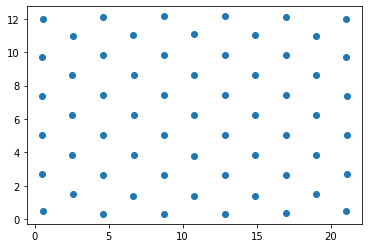

In [4]:
''' 
Generate the primary CoNi cell in planar FCC lattice
'''
x_extend, y_extend = 5, 5
r_equ = 2.49255140368258
cell = supercell_gen(x_extend, y_extend)
cell_t = np.array(cell, dtype=bool)
init_weight = np.array([math.sqrt(3)/2*r_equ, 1/2*r_equ])
coord = np.concatenate([np.where(cell_t)[0].reshape(-1,1),
                        np.where(cell_t)[1].reshape(-1,1)], 1)*init_weight

coord = torch.from_numpy(coord.astype(np.float32)).clone().requires_grad_()
atom_num = len(coord)
# coord = torch.rand(atom_num, 2)*torch.sqrt(torch.tensor(atom_num)).requires_grad_()

n_co = atom_num//2
n_ni = atom_num - n_co

''' 
Embed the corresponding params, also determines the atom specie
'''
p_nico = torch.tensor([
    [2.488746, 2.007018, 27.562015, 27.930410, 8.383453, 4.471175,
    0.429046, 0.633531, 0.443599, 0.820658, -2.693513, -0.076445, 0.241442,
    -2.375626, -2.7, 0, 0.265390, -0.152856, 0.469, -2.699486, 
    27.562015*0.85, 27.562015*1.15],
    [2.505979, 1.975299, 27.206789, 27.206789, 8.679625, 4.629134,
    0.421378, 0.640107, 0.5, 1, -2.541799, -0.219415, 0.733381, -1.589003,
    -2.56, 0, 0.705845, -0.687140, 0.694608, -2.559307,
    27.206789*0.85, 27.206789*1.15]
])
ele_co = torch.cat((torch.zeros((n_co, 1)), torch.ones((n_co, 1))), dim=1)
ele_ni = torch.cat((torch.ones((n_ni, 1)), torch.zeros((n_ni, 1))), dim=1)
ele_list_relax = torch.cat((ele_co, ele_ni), dim=0)
shuffle_i = torch.randperm(ele_list_relax.size(0))
ele_list = ele_list_relax[shuffle_i]

#* Execution
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
param_ = torch.matmul(ele_list, p_nico).to(device)
coord.to(device)
localtime = time.localtime(time.time())
yr_, m_, d_ = localtime[:3]
date = f'{yr_}{m_}{d_}_relax'
pth = f'/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/pyMD/2D_try/EAM/runs/{date}'

m_relax = model(coord, param_).to(device)
# Instantiate optimizer
opt = torch.optim.Adam(m_relax.parameters(), lr=1e-2)
sch = torch.optim.lr_scheduler.StepLR(opt, step_size=1000, gamma = 0.98)

losses = train(m_relax, opt, sch, pth, device, n=400)
weight_ = m_relax.weights.detach().cpu().numpy()
weight_raw = m_relax.weights_.detach().cpu().numpy()
np.save(pth+'weight.npy', weight_)
np.save(pth+'ele_list.npy', ele_list)

plt.scatter(weight_[:, 0], weight_[:, 1])

In [5]:
class model(nn.Module):
    def __init__(self, atom_list, param_list, mass_list, v_list, device):
        super().__init__()
        '''
        atom_list: N*dimension
        param_list: N*number of params per each atom
        per each row:
        r_e, f_e, rho_e, rho_s, alpha, beta, A, B, kappa, lamda,
        f_n0, f_n1, f_n2, f_n3, f_0, f_1, f_2, f_3, eta, f_e
        '''
        #* row1: x-coord, row2: y-coord
        self.weights = nn.Parameter(atom_list)
        self.weights_ = self.weights.clone()
        atom_num = len(atom_list)

        self.ind_inter = torch.combinations(torch.arange(self.weights.size(0)), r=2).to(device)
        ind_inter_f = torch.fliplr(self.ind_inter)
        ind_all = torch.cat((self.ind_inter, ind_inter_f), dim=0)
        ind_all = ind_all[ind_all[:, 0].sort()[1]]
        self.ind_block = torch.split(ind_all, atom_num-1)

        self.rho_list = torch.zeros(atom_num).to(device)
        self.pe_list = torch.zeros(atom_num).to(device)
        self.acc_list = torch.zeros(atom_num, self.weights.size(1)).to(device)
        self.v_list = v_list
        self.mass = mass_list

        self.range = torch.arange(atom_num).to(device)
        self.params = param_list
        self.opt = torch.optim.Adam([self.weights])

    def f_r(self, r, param):
        '''
        Basis function for f(r), tag 1-2
        Param is nD
        '''

        f_e, beta, r_e, lamda = torch.tensor_split(param, param.size(1), dim=1)
        f_e, beta, r_e, lamda = torch.flatten(f_e), torch.flatten(beta), torch.flatten(r_e), torch.flatten(lamda)
        
        nume = f_e*torch.exp(-beta*(r/r_e-1))
        deno = 1 + (r/r_e-lamda)**20
        return nume/deno 

    def phi_r(self, r, param):
        ''' 
        Potential for tag 2-1, atomic pair for same species.
        Param is nD.
        '''
        a, b, r_e, alpha, beta, kappa, lamda = torch.tensor_split(param, param.size(1), dim=1)
        a, b = torch.flatten(a), torch.flatten(b)
        r_e, alpha, beta = torch.flatten(r_e), torch.flatten(alpha), torch.flatten(beta)
        kappa, lamda = torch.flatten(kappa), torch.flatten(lamda)

        l_nume = a*torch.exp(-alpha*(r/r_e-1))
        l_deno = 1 + (r/r_e-kappa)**20
        r_nume = b*torch.exp(-beta*(r/r_e-1))
        r_deno = 1 + (r/r_e-lamda)**20

        return l_nume/l_deno - r_nume/r_deno

    def f_rho(self, rho, param):
        ''' 
        Density function for tag 3-2, param is 1D for the centre atom
        '''
        f_n0, f_n1, f_n2, f_n3, f_0, f_1, f_2, f_3, f_e, rho_n, rho_e, rho_0, rho_s, eta = param
        if rho < rho_n:
            return (f_n0 + f_n1*(rho/rho_n-1)
                + f_n2*(rho/rho_n-1)**2 + f_n3*(rho/rho_n-1)**3)
        elif rho_n <= rho < rho_0:
            return (f_0 + f_1*(rho/rho_e-1)
                + f_2*(rho/rho_e-1)**2 + f_3*(rho/rho_e-1)**3)
        else:
            return f_e*(1-torch.log((rho/rho_s)**eta))*(rho/rho_s)**eta

    def grad_calc(self,):
        ''' 
        Calculate the whole energy with keeping gradient
        '''

        for r_ind in self.range:
            '''
            Extract each atom block containing the centre i and surronding j.
            r_ind corresponds to the index of centre atom.
            '''
            block = self.ind_block[r_ind]
            coord_block = self.weights[block]
            param_block = self.params[block]

            delta_xy = coord_block[:,1]-coord_block[:,0]
            r_blo = torch.norm(delta_xy, dim=1)
            #* So this will be the cutoff ~3 NN?
            effe_r_ind = torch.nonzero(r_blo <= 6)
            r_blo = r_blo[torch.flatten(effe_r_ind)]
            r_blo.retain_grad()
            param_block = param_block[torch.flatten(effe_r_ind)]
            delta_xy = delta_xy[torch.flatten(effe_r_ind)]

            #* Potential energy
            
            fr_0 = self.f_r(r_blo, param_block[:, 0][:, [1, 5, 0, 9]]) #* For f^0(r)
            fr_1 = self.f_r(r_blo, param_block[:, 1][:, [1, 5, 0, 9]]) #* For f^1(r)
            phir_0 = self.phi_r(r_blo, param_block[:, 0][:, [6,7,0,4,5,8,9]]) #* For phi^0(r)
            phir_1 = self.phi_r(r_blo, param_block[:, 1][:, [6,7,0,4,5,8,9]]) #* For phi^1(r)
            phi_01 = 1/2*(fr_1/fr_0*phir_0 + fr_0/fr_1*phir_1) #* For phi^01
            p_e_ = torch.sum(phi_01) #* Potential energy term

            #* Electronic density
            rho_i = torch.sum(self.f_r(r_blo, param_block[:, 1][:, [1, 5, 0, 9]])) #* For f^1(r)
            f_rho_ = self.f_rho(rho_i, param_block[:, 0][:, [10,11,12,13,14,15,16,17,19,20,2,21,3,18]][0]) #* For F(rho)

            self.rho_list[r_ind] = f_rho_
            self.pe_list[r_ind] = p_e_
            e_x = f_rho_ + 1/2*p_e_

            self.opt.zero_grad()
            e_x.backward(retain_graph = True)
            acc = torch.sum(r_blo.grad.reshape(-1,1)*delta_xy/r_blo.reshape(-1,1), dim=0)/self.mass[r_ind] #*N*2
            self.acc_list[r_ind] = acc

        # print(p_e, self.rho_list)
        self.e_total = (torch.sum(self.rho_list) + 1/2*torch.sum(self.pe_list)).detach()
        return 


def train(model, path_save, dt, temp_given, alpha, device=None, n = 1000):

    writer = SummaryWriter(log_dir = path_save)
    length = len(model.weights)
    k_b = constants.k
    ev_j = constants.physical_constants['atomic unit of charge'][0]
    ''' 
    v_list: angstrom / s
    acc: angstrom / s^2
    e_total: eV
    kinetic, potential energy in Tensorboard: eV
    '''

    for i in range(n):
        #* Step 1
        model.grad_calc()
        model.acc_list *= (ev_j*1e20) #* eV -> J
        with torch.no_grad():
            model.weights += (model.v_list*dt + 1/2*model.acc_list*dt**2) #* x-step
        model.v_list += 1/2*model.acc_list*dt
        model.v_list -= torch.sum(model.v_list, 0)/length

        #* Step 2
        model.grad_calc()
        model.acc_list *= (ev_j*1e20)
        model.v_list += 1/2*model.acc_list*dt
        model.v_list -= torch.sum(model.v_list, 0)/length
        k_e_ = 1/2*torch.sum(model.mass.reshape(-1,1)*(model.v_list*1e-10)**2)
        temp_ = k_e_/(3/2*(length-1))/k_b

        writer.add_scalar("Potential energy", model.e_total, i)
        writer.add_scalar("Kinetic energy", k_e_/ev_j, i)
        writer.add_scalar("Temperature", temp_, i)

        if i%100 == 0:
            s_adjust = torch.sqrt((temp_given+(temp_-temp_given)*alpha)/temp_)
            model.v_list *= s_adjust

            # clear_output(True)

#! Periodic boundary condition
#! Check latent bug (?)
#! Memory leak

In [6]:
if __name__ == '__main__':
    use_relax = True
    ''' 
    Generate the primary CoNi cell in planar FCC lattice
    '''
    x_extend, y_extend = 3, 3
    r_equ = 2.49255140368258
    cell = supercell_gen(x_extend, y_extend)
    cell_t = np.array(cell, dtype=bool)
    init_weight = np.array([math.sqrt(3)/2*r_equ, 1/2*r_equ])
    coord = np.concatenate([np.where(cell_t)[0].reshape(-1,1),
                            np.where(cell_t)[1].reshape(-1,1)], 1)*init_weight

    if use_relax:
        coord = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/pyMD/2D_try/EAM/runs/20221026_relaxweight.npy')

    coord = torch.from_numpy(coord.astype(np.float32)).clone().requires_grad_()
    atom_num = len(coord)
    atom_dim = coord.size(1)

    n_co = atom_num//2
    n_ni = atom_num - n_co

    ''' 
    Embed the corresponding params, also determines the atom specie
    '''
    p_nico = torch.tensor([
        [2.488746, 2.007018, 27.562015, 27.930410, 8.383453, 4.471175,
        0.429046, 0.633531, 0.443599, 0.820658, -2.693513, -0.076445, 0.241442,
        -2.375626, -2.7, 0, 0.265390, -0.152856, 0.469, -2.699486, 
        27.562015*0.85, 27.562015*1.15], #* Ni
        [2.505979, 1.975299, 27.206789, 27.206789, 8.679625, 4.629134,
        0.421378, 0.640107, 0.5, 1, -2.541799, -0.219415, 0.733381, -1.589003,
        -2.56, 0, 0.705845, -0.687140, 0.694608, -2.559307,
        27.206789*0.85, 27.206789*1.15] #* Co
    ])
    m_nico = torch.tensor([ 
        [58.6934],
        [58.9332]
    ])*constants.u

    ele_co = torch.cat((torch.zeros((n_co, 1)), torch.ones((n_co, 1))), dim=1)
    ele_ni = torch.cat((torch.ones((n_ni, 1)), torch.zeros((n_ni, 1))), dim=1)
    ele_list = torch.cat((ele_co, ele_ni), dim=0)
    shuffle_i = torch.randperm(ele_list.size(0))
    ele_list = ele_list[shuffle_i]
    if use_relax:
        ele_list = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/pyMD/2D_try/EAM/runs/20221026_relaxele_list.npy')
        ele_list = torch.from_numpy(ele_list.astype(np.float32))

    #* Execution
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    param_ = torch.matmul(ele_list, p_nico)
    mass_ = torch.flatten(torch.matmul(ele_list, m_nico))


    #* Velocity
    temp = 200
    k_b = constants.k
    v_list = torch.rand(atom_num, atom_dim)*torch.sqrt(3*(1-1/atom_dim)*k_b*temp/mass_.reshape(-1,1))*1e10
    v_list -= torch.sum(v_list, 0)/atom_num

    #* To device
    v_list = v_list.to(device)
    mass_ = mass_.to(device)
    param_ = param_.to(device)
    coord = coord.to(device)


    localtime = time.localtime(time.time())
    yr_, m_, d_ = localtime[:3]
    date = f'{yr_}{m_}{d_}'
    pth = f'/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/pyMD/2D_try/EAM/runs/{date}'

    m = model(coord, param_, mass_, v_list, device).to(device)

    dt = torch.tensor(1e-15).to(device) #* Time step, 1 fs = 1e-15 s
    alpha = 0.75 #* For temperature adjusting
    train(m, pth, dt, temp, alpha, device, n=100000)
    weight_ = m.weights.detach().cpu().numpy()
    weight_raw = m.weights_.detach().cpu().numpy()
    plt.scatter(weight_[:, 0], weight_[:, 1])

KeyboardInterrupt: 

In [8]:
print(torch.cuda.max_memory_allocated())

4190434816


In [6]:
import pandas as pd
from sys import getsizeof
def get_memory(threshold=1048576):
    '''查看变量占用内存情况

    :param threshold: 仅显示内存数值大于等于threshold的变量, 默认为 1MB=1048576B
    '''
    memory_df=pd.DataFrame(columns=['name', 'memory', 'convert_memory'])
    i=0
    for key in list(globals().keys()):
        memory = eval("getsizeof({})".format(key))
        if memory<threshold:
            continue
        if(memory>1073741824):# GB
            unit='GB'
            convert_memory=round(memory/1073741824)
        elif(memory>1048576):# MB
            unit='MB'
            convert_memory=round(memory/1048576)           
        elif(memory>1024):# KB
            unit='KB'
            convert_memory=round(memory/1024)  
        else:
            unit='B' 
            convert_memory = memory
        memory_df.loc[i]=[key, memory, str(convert_memory)+unit]
        i=i+1
    # 按照内存占用大小降序排序    
    memory_df.sort_values("memory",inplace=True,ascending=False)
    return memory_df
    
memory_df = get_memory()
memory_df

,name,memory,convert_memory
